In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time
import pathlib

In [3]:
import numpy as np
import pandas as pd
from numba import jit

In [4]:
from sklearn.metrics.pairwise import haversine_distances
from scipy.spatial.distance import pdist
from sklearn.neighbors import DistanceMetric

In [5]:
DATA_DIR = pathlib.Path("../../data/")

# Loading data

In [6]:
locations = pd.read_csv(DATA_DIR.joinpath("locations.csv"), header=None)

In [7]:
locations.columns = ["lat", "lon"]

In [8]:
def measure_time(df, f, ns=np.logspace(9, 14, 6, base=2)):
    """Measure timings for distance function `f`."""

    timings = {}

    for num in ns:
        sample = df.sample(int(num), replace=False)
        v = sample.values
        start_ts = time.time()
        distances = f(v)
        end_ts = time.time()
        timings[num] = end_ts - start_ts
    return pd.Series(timings)

Text(0.5, 1.0, 'Timings for various distance functions')

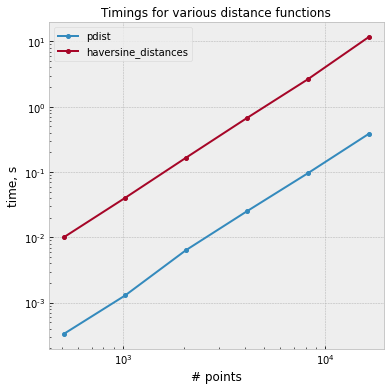

In [9]:
plt.figure(figsize=(6,6))

for dist_func, data in zip([pdist, haversine_distances], [locations, locations/180.]):
    pdist_timings = measure_time(data, dist_func)
    pdist_timings.plot(ms=4, marker="o", label=dist_func.__name__)

plt.legend(loc=0)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("# points")
plt.ylabel("time, s")
plt.title("Timings for various distance functions", fontsize=12)

## Reimplementing haversine metric

See [`_dist_metrics.pyx` from `sklearn` for more details](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/neighbors/_dist_metrics.pyx#L1001). We'll try to reimplement it with Numba.

In [10]:
@jit
def haversine_distances_jit(d):
    """Numba version of haversine distance."""

    x = d[:, 0]
    y = d[:, 1]
    x_e = np.expand_dims(x, 1)

    sin_0 = np.sin(0.5 * (x - x_e))
    sin_1 = np.sin(0.5 * (y - np.expand_dims(y, 1)))
    cos_0 = np.cos(x) * np.cos(x_e)
    return 2 * np.arcsin(np.sqrt(sin_0 * sin_0 + cos_0 * sin_1 * sin_1))

In [11]:
%timeit haversine_distances_jit(locations.values[:100])

567 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Run the following (and all similar cells) twice to eliminate JIT compilation time from the timings:

Text(0.5, 1.0, 'Timings for various distance functions')

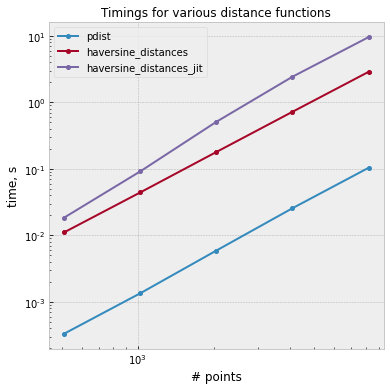

In [13]:
plt.figure(figsize=(6,6))

for dist_func, data in zip([pdist, haversine_distances, haversine_distances_jit],
                           [locations, locations/180., locations/180.]):
    pdist_timings = measure_time(data, dist_func, ns=np.logspace(9, 13, 5, base=2))
    pdist_timings.plot(ms=4, marker="o", label=dist_func.__name__)

plt.legend(loc=0)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("# points")
plt.ylabel("time, s")
plt.title("Timings for various distance functions", fontsize=12)

Naive version in Numba is nearly the same as SciPy, as it uses very similar mechanics from NumPy.

In [14]:
@jit
def haversine_distances_loop(d):
    """Numba version of haversine distance."""

    dist_mat = np.zeros((d.shape[0], d.shape[0]))

    for i in range(d.shape[0]):
        for j in range(i+1, d.shape[0]):
            sin_0 = np.sin(0.5 * (d[i, 0] - d[j, 0]))
            sin_1 = np.sin(0.5 * (d[i, 1] - d[j, 1]))
            cos_0 = np.cos(d[i, 0]) * np.cos(d[j, 0])
            dist_mat[i, j] = 2 * np.arcsin(np.sqrt(sin_0 * sin_0 + cos_0 * sin_1 * sin_1))
            dist_mat[j, i] = dist_mat[i, j]
    return dist_mat

In [15]:
%timeit haversine_distances_loop(locations.values[:100])

321 µs ± 3.86 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Text(0.5, 1.0, 'Timings for various distance functions')

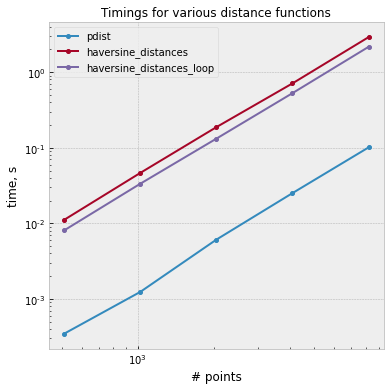

In [27]:
plt.figure(figsize=(6,6))

for dist_func, data in zip([pdist, haversine_distances, haversine_distances_loop],
                           [locations, locations/180., locations/180.]):
    pdist_timings = measure_time(data, dist_func, ns=np.logspace(9, 13, 5, base=2))
    pdist_timings.plot(ms=4, marker="o", label=dist_func.__name__)

plt.legend(loc=0)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("# points")
plt.ylabel("time, s")
plt.title("Timings for various distance functions", fontsize=12)

Unrolled version is somewhat faster, but still much slower compared to `pdist` (a reference for which we can reasonably run the clustering). Add threading:

In [17]:
from numba import prange

@jit(parallel=True)
def haversine_distances_parallel(d):
    """Numba version of haversine distance."""

    dist_mat = np.zeros((d.shape[0], d.shape[0]))

    # We parallelize outer loop to keep threads busy
    for i in prange(d.shape[0]):
        for j in range(i+1, d.shape[0]):
            sin_0 = np.sin(0.5 * (d[i, 0] - d[j, 0]))
            sin_1 = np.sin(0.5 * (d[i, 1] - d[j, 1]))
            cos_0 = np.cos(d[i, 0]) * np.cos(d[j, 0])
            dist_mat[i, j] = 2 * np.arcsin(np.sqrt(sin_0 * sin_0 + cos_0 * sin_1 * sin_1))
            dist_mat[j, i] = dist_mat[i, j]
    return dist_mat

In [18]:
%timeit haversine_distances_parallel(locations.values[:100])

241 µs ± 40.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'Timings for various distance functions')

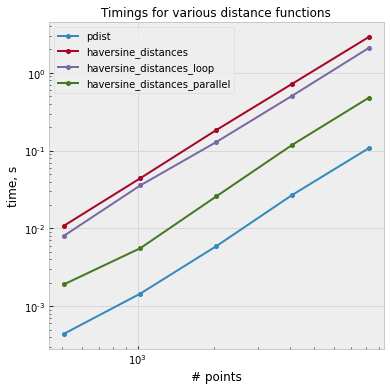

In [28]:
plt.figure(figsize=(6,6))

for dist_func, data in zip([pdist, haversine_distances, haversine_distances_loop, haversine_distances_parallel],
                           [locations, locations/180., locations/180., locations/180.]):
    pdist_timings = measure_time(data, dist_func, ns=np.logspace(9, 13, 5, base=2))
    pdist_timings.plot(ms=4, marker="o", label=dist_func.__name__)

plt.legend(loc=0)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("# points")
plt.ylabel("time, s")
plt.title("Timings for various distance functions", fontsize=12)

Much better, about 5 time slower than `pdist` (not 15 times, as SciPy version). Let's check `fastmath` just in case:

In [20]:
from numba import prange

@jit(parallel=True, fastmath=True)
def haversine_distances_parallel_fm(d):
    """Numba version of haversine distance."""

    dist_mat = np.zeros((d.shape[0], d.shape[0]))

    # We parallelize outer loop to keep threads busy
    for i in prange(d.shape[0]):
        for j in range(i+1, d.shape[0]):
            sin_0 = np.sin(0.5 * (d[i, 0] - d[j, 0]))
            sin_1 = np.sin(0.5 * (d[i, 1] - d[j, 1]))
            cos_0 = np.cos(d[i, 0]) * np.cos(d[j, 0])
            dist_mat[i, j] = 2 * np.arcsin(np.sqrt(sin_0 * sin_0 + cos_0 * sin_1 * sin_1))
            dist_mat[j, i] = dist_mat[i, j]
    return dist_mat

Text(0.5, 1.0, 'Timings for various distance functions')

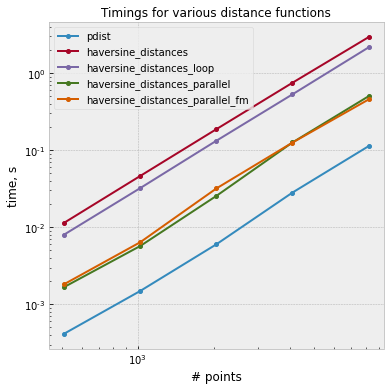

In [29]:
plt.figure(figsize=(6,6))

for dist_func, data in zip([pdist, haversine_distances, haversine_distances_loop,
                            haversine_distances_parallel, haversine_distances_parallel_fm],
                           [locations, locations/180., locations/180., locations/180., locations/180.]):
    pdist_timings = measure_time(data, dist_func, ns=np.logspace(9, 13, 5, base=2))
    pdist_timings.plot(ms=4, marker="o", label=dist_func.__name__)

plt.legend(loc=0)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("# points")
plt.ylabel("time, s")
plt.title("Timings for various distance functions", fontsize=12)

Ok, `fastmath=True` adds nothing.

# Validation

In [22]:
dhv = haversine_distances_parallel(locations.values[:100])
dhv_scipy = haversine_distances(locations.values[:100])

In [23]:
dhv_scipy.max()

0.26203988966358793

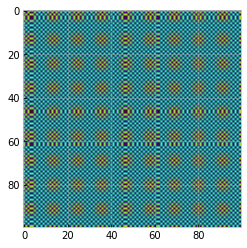

In [24]:
plt.imshow(dhv, vmin=0., vmax=0.3)

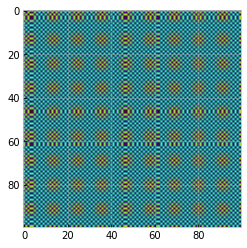

In [25]:
plt.imshow(dhv_scipy, vmin=0., vmax=0.3)

In [26]:
dhv - dhv_scipy

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])